In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np

from cvxopt import matrix, solvers

from tools import Data, Predictions


""" A PDF reweighting tool """

__author__ = 'Stefano Carrazza & Zahari Kassabov'
__license__ = 'GPL'
__version__ = '1.0.0'
__email__ = 'stefano.carrazza@cern.ch'




In [123]:
# load data, invcovmat and predictions
dt = Data('data/data.csv.tgz', 'data/invcovmat.csv.tgz')
th = Predictions('data/predictions.csv.tgz')

# retreive cv and invcovmat as numpy arrays
cv    = dt.get_data()
sigma = dt.get_invcovmat()
predictions     = th.get_predictions()


 Opening data file: data/data.csv.tgz
 Opening data file: data/invcovmat.csv.tgz
 Opening predictions file: data/predictions.csv.tgz


In [124]:
def effective_number_of_replicas(w):
    N = len(w)
    w = w*N
    return np.exp(np.nansum(w*np.log(N/w))/N)

In [125]:
effective_number_of_replicas(np.ones(100))

1.0

In [126]:
def chi2_per_replica(sigma, cv, predictions):
    diff = predictions - cv
    return np.einsum('id,de,ie -> i',diff, sigma, diff )/len(sigma)

In [127]:
def nnpdf_weights(sigma, cv, predictions):
    chi2s = chi2_per_replica(sigma, cv, predictions)*len(sigma)
    logw = ((len(sigma) - 1)/2)*np.log(chi2s) - 0.5*chi2s
    logw -= np.mean(logw)
    w = np.exp(logw)
    w /= sum(w)
    return w

In [158]:
nw = nnpdf_weights(sigma, cv, predictions)

In [159]:
effective_number_of_replicas(nw)

2.4194382277024666

In [130]:
def chi2(w, sigma, cv, predictions):

    w = np.ravel(w)
    diff = w@predictions - cv

    chi2 = diff@sigma@diff/len(diff)

    return chi2

The chi² function is

v = (w@P) - cv
chi² = v@sigma@v

Therefore we need to minimize 1/2*w@P@W + q@w as a function of w


In [356]:
q = -cv@sigma@predictions.T
A = np.ones_like(q)

#b = np.zeros_like(P[0])
b = float(1)

G = -np.eye(len(A))

h = np.zeros(len(A))

q = matrix(q)
A = matrix(A)
b = matrix(b)
G = matrix(G)
h = matrix(h)

mp = np.mean(predictions,axis=0)

mean_chi2 = (mp@sigma@mp)

solvers.options['feastol'] = 1e-16

mp = np.mean(predictions, axis=0)
penalty_scale = np.abs(0.5*mp@sigma@mp -cv@sigma@mp)

def get_min_weights(penalty):
    
    eff_pelnalty = penalty*penalty_scale
    P = predictions@sigma@predictions.T + np.eye(len(predictions))*eff_pelnalty



    P = matrix(P)


    
    sol = solvers.qp(P, q, G, h, A.T, b)

    w = np.array(sol['x']).ravel()
    return w





In [357]:
penalty_scale

171045.6639095734

In [375]:
w = get_min_weights(0.01)

In [376]:
effective_number_of_replicas(w)

33.693561768259315

In [377]:
(w > 0).all()

True

In [378]:
chi2(w, sigma, cv, predictions)

1.1310003801055741

In [379]:
sum(w)

1.0000000000000002

In [380]:
%matplotlib inline

In [381]:
w.min()

7.255668463804438e-189

In [382]:
w.max()

0.066157585740448596

In [383]:
np.sort(w)

array([  7.25566846e-189,   9.13086153e-189,   1.12347234e-188,
         1.28999188e-188,   1.46315910e-188,   1.50938405e-188,
         1.60646004e-188,   1.67045113e-188,   1.79025267e-188,
         1.83950111e-188,   1.93991622e-188,   2.10289831e-188,
         2.24996434e-188,   2.30446970e-188,   2.32396387e-188,
         2.86612092e-188,   3.17002438e-188,   3.44292598e-188,
         3.81072580e-188,   3.86574347e-188,   3.88370621e-188,
         4.26474418e-188,   4.39330768e-188,   5.33845447e-188,
         5.43072660e-188,   6.44251603e-188,   6.91984065e-188,
         1.30938844e-187,   2.19843156e-187,   2.65930496e-187,
         3.67353696e-187,   7.34105903e-187,   2.64905755e-186,
         1.01632923e-182,   9.47453710e-004,   1.16668688e-003,
         1.20650633e-003,   1.31217977e-003,   1.45996398e-003,
         1.64396353e-003,   2.77495093e-003,   3.19706817e-003,
         3.24882230e-003,   5.47278455e-003,   7.90152052e-003,
         8.67676367e-003,   9.32259423e-

In [384]:
np.median(w)

0.0022094572296667706

In [385]:
np.argsort(w)[-15:]

array([61, 68, 37, 15, 63, 70, 22,  0, 32, 20, 78, 21, 25, 35, 53])

In [386]:
chi2(w, sigma, cv, predictions)

1.1310003801055741

In [387]:
np.mean(predictions, axis=0)@sigma@np.mean(predictions, axis=0)

349336.21890748374

In [388]:
effective_number_of_replicas(w)

33.693561768259315

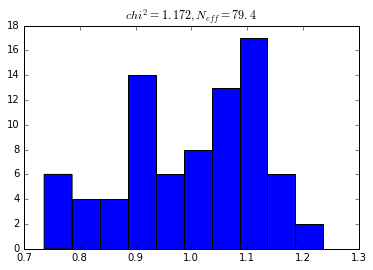

In [396]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
solvers.options['show_progress'] = False
def show_sol(penalty=0):
    w = get_min_weights(penalty)
    plt.title("$chi^2=%.3f, N_{eff}=%.1f$" % (chi2(w, predictions=predictions, 
                                                   cv=cv, sigma=sigma),
                                              effective_number_of_replicas(w)))
    w*=len(A)
    plt.hist(w)

interact(show_sol, penalty=(0,0.50,0.0001))
    





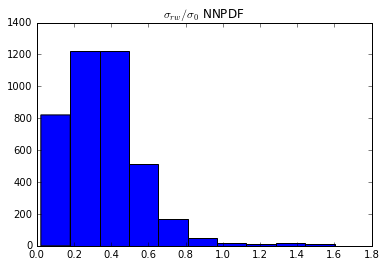

In [397]:
#w = get_min_weights(2000)
w = nw
avg = np.average(predictions, weights=w, axis=0)
var = np.average((predictions - avg)**2, weights=w, axis=0)
rwstd = np.sqrt(var)
origstd = np.std(predictions, axis=0)
ratio = rwstd/origstd
plt.hist(ratio)
plt.title(r'$\sigma_{rw}/\sigma_0$ NNPDF')

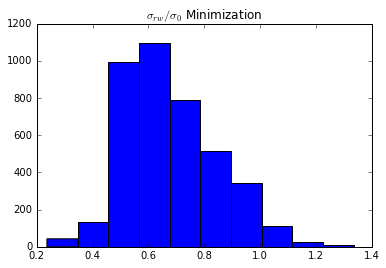

In [409]:
w = get_min_weights(0)
#w = nw
avg = np.average(predictions, weights=w, axis=0)
var = np.average((predictions - avg)**2, weights=w, axis=0)
rwstd = np.sqrt(var)
origstd = np.std(predictions, axis=0)
ratio = rwstd/origstd
plt.hist(ratio)
plt.title(r'$\sigma_{rw}/\sigma_0$ Minimization')

In [407]:
w = get_min_weights(0.0107)
effective_number_of_replicas(w)

34.95041932169898

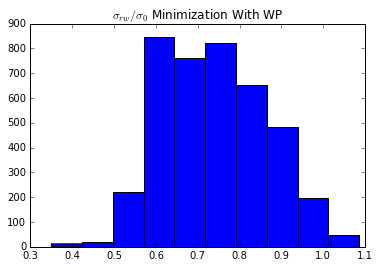

In [408]:
w = get_min_weights(0.0107)
#w = nw
avg = np.average(predictions, weights=w, axis=0)
var = np.average((predictions - avg)**2, weights=w, axis=0)
rwstd = np.sqrt(var)
origstd = np.std(predictions, axis=0)
ratio = rwstd/origstd
plt.hist(ratio)
plt.title(r'$\sigma_{rw}/\sigma_0$ Minimization With WP')

(1e-07, 10000000.0)

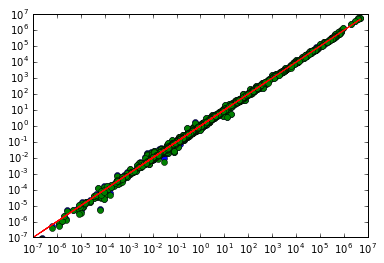

In [169]:
plt.plot(cv, predictions.mean(axis=0), 'o')
plt.plot(cv, w@predictions, 'o')

plt.plot(cv, cv)
plt.xscale('log')
plt.yscale('log')


In [11]:
%matplotlib qt
import matplotlib.pyplot as plt

In [12]:
plt.plot(predictions.mean(axis=0)/cv, 'o')
plt.plot(w@predictions/cv, 'o')

In [72]:
w

array([  5.00486259e-04,   4.87361116e-04,   1.08870425e-03,
         1.08033101e-01,   7.30367023e-04,   3.29872379e-04,
         5.17924095e-04,   3.40926299e-04,   3.47297778e-04,
         4.80942184e-04,   5.35189484e-04,   5.66683058e-04,
         4.67528242e-04,   9.06750894e-04,   5.78990423e-04,
         9.91329139e-04,   4.91905118e-04,   8.89457121e-05,
         1.16912163e-04,   9.94579626e-02,   5.89079037e-04,
         5.28928228e-03,   9.56105719e-05,   6.91296167e-04,
         5.56540814e-04,   8.15352064e-04,   3.94852844e-04,
         6.55589210e-04,   5.67950597e-04,   5.28232225e-04,
         5.04999366e-04,   5.24003695e-04,   5.21785174e-04,
         9.15699643e-02,   2.92109776e-04,   8.64029787e-04,
         6.40017813e-04,   2.25907622e-03,   5.10905903e-04,
         4.19384684e-04,   5.52341918e-04,   7.04245808e-04,
         5.82070481e-04,   6.02963120e-04,   1.84826990e-04,
         2.55449831e-04,   1.08056162e-03,   7.42146671e-04,
         4.23208068e-04,